In [29]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
from ellipse import LsqEllipse
from skimage.measure import EllipseModel, ransac


In [2]:
# 이미지 경로 (현재 노트북 기준)
img_path = "/mnt/d/ev-auto-charging/vision/Inference/image/original_left_view/left_view.png"   # 파일 이름 또는 경로 수정

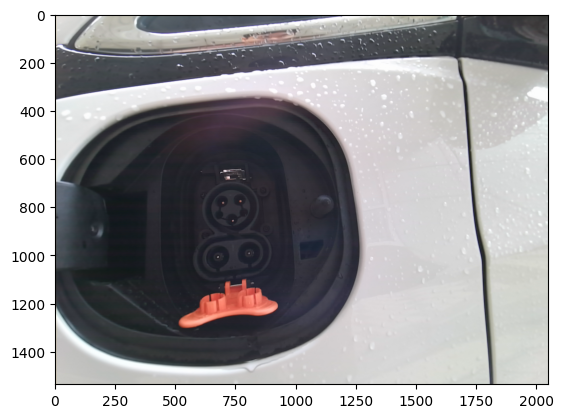

In [3]:
# 1. 이미지 불러오기
img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [33]:
json_path = "/mnt/d/ev-auto-charging/vision/Inference/image/detect_left_view/left_view_bbox.json"

with open(json_path, "r", encoding="utf-8") as f:
    bbox_dicts = json.load(f)
# bbox 리스트만 추출
bboxes = [item["bbox"] for item in bbox_dicts]

# 전체 박스 포함하는 ROI 계산
x1 = int(min([b[0] for b in bboxes]))
y1 = int(min([b[1] for b in bboxes]))
x2 = int(max([b[2] for b in bboxes]))
y2 = int(max([b[3] for b in bboxes]))

roi = (x1, y1, x2, y2)
print("==> ROI Box:", roi)

==> ROI Box: (609, 695, 852, 1058)


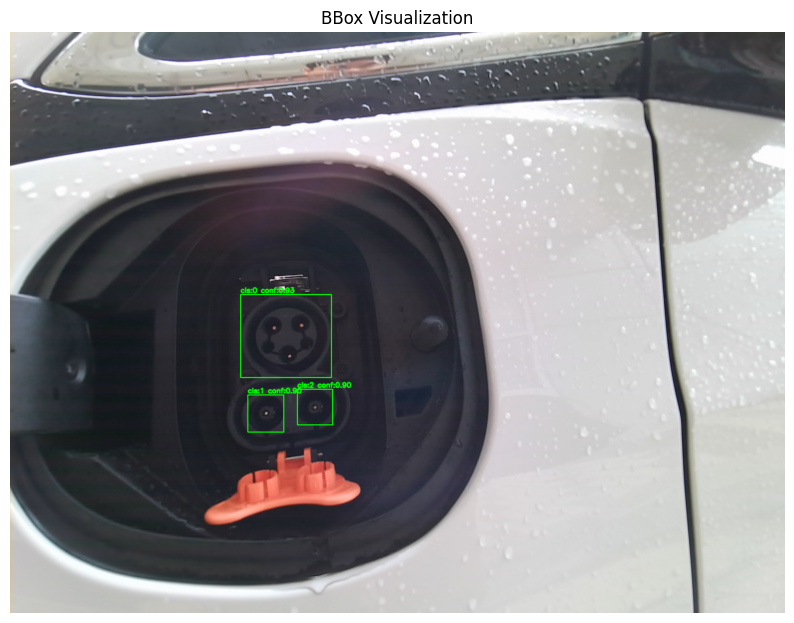

In [5]:
img_draw = img.copy()
# ---- bbox 그리기 ----
for obj in bbox_dicts:
    x1, y1, x2, y2 = map(int, obj["bbox"])
    cls = obj["class"]
    conf = obj["confidence"]

    # rectangle
    cv2.rectangle(img_draw, (x1, y1), (x2, y2), (0,255,0), 2)

    # label text
    label = f"cls:{cls} conf:{conf:.2f}"
    cv2.putText(img_draw, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX,
                0.6, (0,255,0), 2, cv2.LINE_AA)

# ---- 시각화 ----
plt.figure(figsize=(10,10))
plt.title("BBox Visualization")
plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

(np.float64(-0.5), np.float64(252.5), np.float64(372.5), np.float64(-0.5))

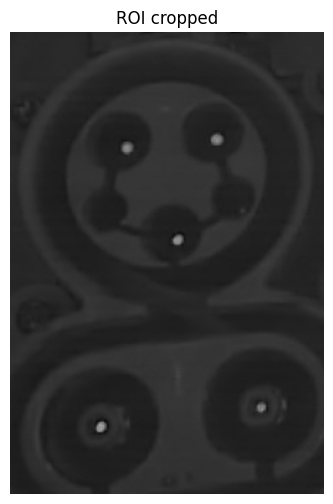

In [34]:
# ROI 자르기
x1, y1, x2, y2 = roi
roi = gray[y1-5:y2+5, x1-5:x2+5]

plt.figure(figsize=(6,6))
plt.title("ROI cropped")
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.axis("off")

(np.float64(-0.5), np.float64(252.5), np.float64(372.5), np.float64(-0.5))

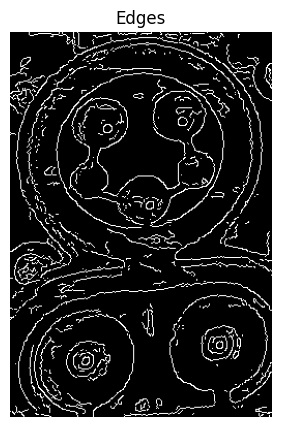

In [78]:
# 2. 엣지 추출
blur = cv2.GaussianBlur(roi, (5,5), 0)
edges = cv2.Canny(blur, 1, 10)

plt.figure(figsize=(5,5))
plt.title("Edges")
plt.imshow(edges, cmap='gray')
plt.axis("off")

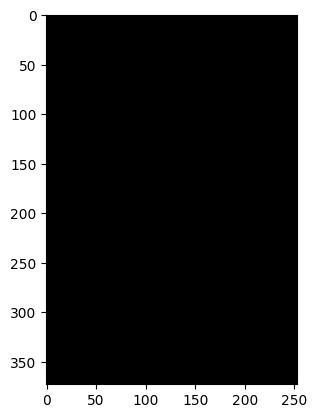

In [79]:
kernel = np.ones((3,3), np.uint8)
edges_sep = cv2.erode(edges, kernel, iterations=1)
plt.imshow(edges_sep, cmap='gray')


(np.float64(-0.5), np.float64(252.5), np.float64(372.5), np.float64(-0.5))

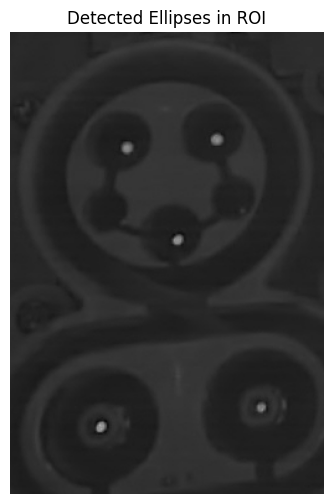

In [80]:
# 3. 컨투어 탐색
contours, _ = cv2.findContours(edges_sep, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

ellipses = []
for cnt in contours:
    if len(cnt) < 1:
        continue  # fitEllipse는 최소 5점 필요
    area = cv2.contourArea(cnt)
    if area < 30:
        continue  # 작은 노이즈 제거
    
    ellipse = cv2.fitEllipse(cnt)
    (cx, cy), (major, minor), angle = ellipse

    # 간단한 필터링
    aspect_ratio = max(major, minor) / (min(major, minor) + 1e-6)
    if aspect_ratio < 6 and major > 5 and minor > 5:
        ellipses.append(ellipse)

# 4. 시각화
roi_color = cv2.cvtColor(roi, cv2.COLOR_GRAY2BGR)

for ellipse in ellipses:
    cv2.ellipse(roi_color, ellipse, (0,0,255), 2)

plt.figure(figsize=(6,6))
plt.title("Detected Ellipses in ROI")
plt.imshow(cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB))
plt.axis("off")

In [71]:
# === 0) 파라미터 (필요시만 조정) ===
canny_t1, canny_t2 = 5, 30     # 약하게 엣지
sobel_ksize = 3                 # 3 또는 5 정도
w_grad, w_edge = 1.0, 1.0       # 합성 가중치
min_area = 100                  # 너무 작은 잡음 컨투어 제거